In [1]:
#check if seaborn is installed

import subprocess

try:
    subprocess.check_call(['pip', 'show', 'seaborn'])
except subprocess.CalledProcessError:
    # Seaborn is not installed
    %pip install seaborn
else:
    print('Seaborn is already installed.')

Seaborn is already installed.


In [2]:
#check if xgboost is installed

import subprocess

try:
    subprocess.check_call(['pip', 'show', 'xgboost'])
except subprocess.CalledProcessError:
    # xgboost is not installed
    %pip install xgboost
else:
    print('xgboost is already installed.')

xgboost is already installed.


In [3]:
# import necessary libraries

import pandas as pd
import numpy as np
import xgboost as xgb
import datetime


from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder


# Set display options to show all rows and columns
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [4]:
# import populated_df as df

df = pd.read_csv('populated_df.csv')

In [5]:
# check the label value counts

df['Label'].value_counts()

0    7588
1     290
Name: Label, dtype: int64

<AxesSubplot: title={'center': 'Class distribution of the target(Label) variable'}>

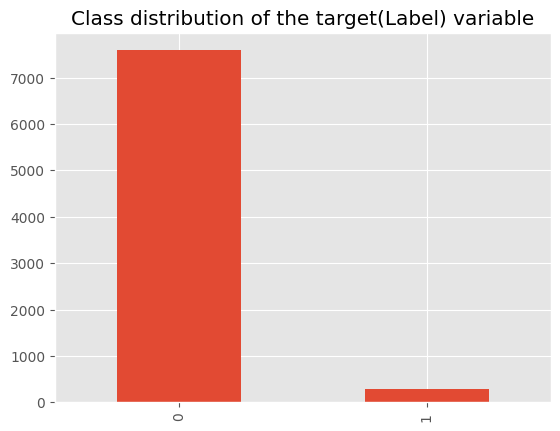

In [6]:
# plot the dispersion of the target variable

value_counts = df['Label'].value_counts()
value_counts.plot(kind="bar", title="Class distribution of the target(Label) variable")

In [7]:
df["S_Giriş Zamanı"] = pd.to_datetime(df["S_Giriş Zamanı"])
df["S_Çıkış Zamanı"] = pd.to_datetime(df["S_Çıkış Zamanı"])

In [8]:
#describe the latest df 

df.dtypes

Üye                                int64
Sınav                              int64
Konu                               int64
Sınav Türü                         int64
Doğru Sayısı                       int64
Yanlış Sayısı                      int64
Boş Sayısı                         int64
Puan                               int64
S_Giriş Zamanı            datetime64[ns]
S_Çıkış Zamanı            datetime64[ns]
S_süre                             int64
GirişLog                           int64
Sınıf                              int64
Ders                               int64
Aktif Materyal Sayısı              int64
Toplam Materyal Sayısı             int64
cum_lecture_time                   int64
cum_study_time                     int64
total_study_time                   int64
Label                              int64
Overlap (secs.)                  float64
dtype: object

In [9]:
df["S_süre"]

0       237
1       241
2       149
3       659
4       115
       ... 
7873    254
7874     19
7875    143
7876     45
7877     53
Name: S_süre, Length: 7878, dtype: int64

In [10]:
df["S_Çıkış Zamanı"]-df["S_Giriş Zamanı"]

0       0 days 00:04:12
1       0 days 00:04:17
2       0 days 01:44:29
3       0 days 00:11:16
4      24 days 00:38:31
             ...       
7873    0 days 00:04:41
7874    0 days 00:00:46
7875    0 days 00:05:06
7876    0 days 00:01:11
7877    0 days 00:03:35
Length: 7878, dtype: timedelta64[ns]

In [11]:
#count if duration between S_Çıkış Zamanı and S_Giriş Zamanı more than 1 day

(df["S_Çıkış Zamanı"]-df["S_Giriş Zamanı"] > datetime.timedelta(days=1)).value_counts()

False    7430
True      448
dtype: int64

In [12]:
# create a trial_df from deep copy of df

trial_df = df.copy(deep=True)
pd.options.display.float_format = '{:.0f}'.format


In [13]:
# check the difference between (S_Çıkış Zamanı-S_Giriş Zamanı) and S_süre

trial_df["S_Çıkış - S_Giriş"] = (trial_df["S_Çıkış Zamanı"]-trial_df["S_Giriş Zamanı"]).dt.total_seconds()

In [14]:
# get the columns of S_Çıkış - S_Giriş and S_süre

trial_df[["S_Çıkış - S_Giriş", "S_süre", "Label"]]



,S_Çıkış - S_Giriş,S_süre,Label
0,252,237,0
1,257,241,0
2,6269,149,0
3,676,659,0
4,2075911,115,0
...,...,...,...
7873,281,254,0
7874,46,19,1
7875,306,143,0
7876,71,45,0


In [15]:
filtered_trial_df = trial_df[trial_df["Label"] == 1]
filtered_trial_df[["S_Çıkış - S_Giriş", "S_süre", "Label"]]

,S_Çıkış - S_Giriş,S_süre,Label
7,93,73,1
10,142,119,1
12,122,100,1
16,58,33,1
17,54,29,1
...,...,...,...
7794,48,23,1
7797,44,18,1
7867,72,48,1
7872,68,43,1


In [16]:
#calculate the diffrerence between S_Çıkış - S_Giriş and S_süre and divide it by S_süre to get the percentage

filtered_trial_df["Difference"] = filtered_trial_df.apply(lambda row: (row["S_Çıkış - S_Giriş"] - row["S_süre"]) / row["S_süre"], axis=1)

filtered_trial_df[["S_Çıkış - S_Giriş", "S_süre", "Label", "Difference"]]

C:\Users\Samsung\AppData\Local\Temp\ipykernel_15180\3935778644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trial_df["Difference"] = filtered_trial_df.apply(lambda row: (row["S_Çıkış - S_Giriş"] - row["S_süre"]) / row["S_süre"], axis=1)


,S_Çıkış - S_Giriş,S_süre,Label,Difference
7,93,73,1,0
10,142,119,1,0
12,122,100,1,0
16,58,33,1,1
17,54,29,1,1
...,...,...,...,...
7794,48,23,1,1
7797,44,18,1,1
7867,72,48,1,0
7872,68,43,1,1


In [17]:
# describe the difference column

filtered_trial_df["Difference"].describe()

count      290
mean      1842
std      25606
min          0
25%          0
50%          0
75%          1
max     430977
Name: Difference, dtype: float64

In [18]:
#it seems mean value is so high, let's check the max value

filtered_trial_df["Difference"].max()

# max value is so high, so it makes possible to say that this outlier uplifts the mean value of difference column

430977.2

In [19]:
#check the number of rows that have difference value more than 1 (100%+ difference)

(filtered_trial_df["Difference"] > 1).sum()

50

C:\Users\Samsung\AppData\Local\Temp\ipykernel_15180\828739928.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trial_df['value_range'] = pd.cut(filtered_trial_df['Difference'], bins=bins, labels=bin_labels, right=False)


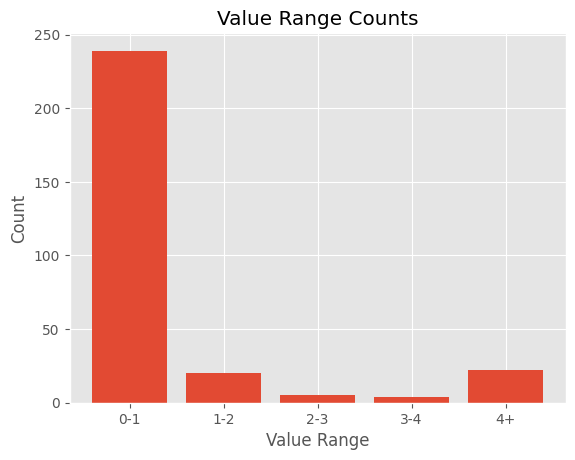

In [20]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'filtered_trial_df' with a column named 'Difference'
# Replace 'filtered_trial_df' and 'Difference' with your actual DataFrame and column names

# Define the value ranges for the bins
bins = [0, 1, 2, 3, 4, float('inf')]

# Use the 'cut' function to categorize the values into the defined bins
bin_labels = ['0-1', '1-2', '2-3', '3-4', '4+']
filtered_trial_df['value_range'] = pd.cut(filtered_trial_df['Difference'], bins=bins, labels=bin_labels, right=False)

# Count the occurrences in each value range
value_counts = filtered_trial_df['value_range'].value_counts()

# Sort the value counts by index (value range)
value_counts = value_counts.sort_index()

# Create a bar chart to visualize the counts
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('Value Range')
plt.ylabel('Count')
plt.title('Value Range Counts')

# Show the plot
plt.show()

In [21]:
filtered_trial_df["value_range"].value_counts()

0-1    239
4+      22
1-2     20
2-3      5
3-4      4
Name: value_range, dtype: int64

In [22]:
trial_df["Difference"] = trial_df.apply(lambda row: (row["S_Çıkış - S_Giriş"] - row["S_süre"]) / row["S_süre"], axis=1)

trial_df[["S_Çıkış - S_Giriş", "S_süre", "Label", "Difference"]]

,S_Çıkış - S_Giriş,S_süre,Label,Difference
0,252,237,0,0
1,257,241,0,0
2,6269,149,0,41
3,676,659,0,0
4,2075911,115,0,18050
...,...,...,...,...
7873,281,254,0,0
7874,46,19,1,1
7875,306,143,0,1
7876,71,45,0,1


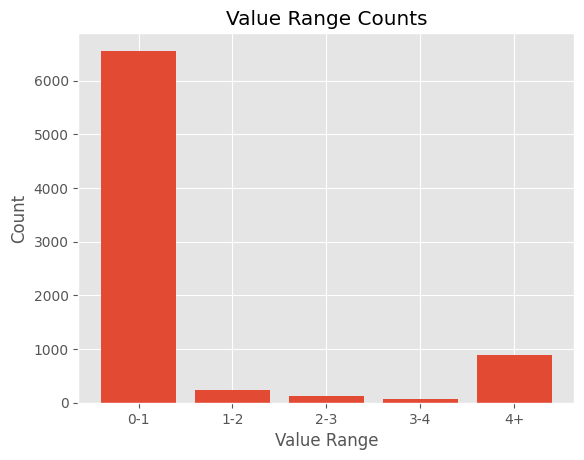

In [23]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'trial_df' with a column named 'Difference'
# Replace 'trial_df' and 'Difference' with your actual DataFrame and column names

# Define the value ranges for the bins
bins = [0, 1, 2, 3, 4, float('inf')]

# Use the 'cut' function to categorize the values into the defined bins
bin_labels = ['0-1', '1-2', '2-3', '3-4', '4+']
trial_df['value_range'] = pd.cut(trial_df['Difference'], bins=bins, labels=bin_labels, right=False)

# Count the occurrences in each value range
value_counts = trial_df['value_range'].value_counts()

# Sort the value counts by index (value range)
value_counts = value_counts.sort_index()

# Create a bar chart to visualize the counts
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('Value Range')
plt.ylabel('Count')
plt.title('Value Range Counts')

# Show the plot
plt.show()

In [24]:
trial_df["value_range"].value_counts()

0-1    6558
4+      884
1-2     243
2-3     121
3-4      71
Name: value_range, dtype: int64

In [25]:
#drop if the difference more than 100% according to S_süre

trial_df.drop(trial_df[trial_df['Difference'] > 1].index, inplace=True)

In [26]:
trial_df["value_range"].value_counts()

0-1    6558
1-2      23
2-3       0
3-4       0
4+        0
Name: value_range, dtype: int64

In [27]:
trial_df["Label"].value_counts()

0    6342
1     240
Name: Label, dtype: int64

In [28]:
df=trial_df

In [29]:
df.dtypes

Üye                                int64
Sınav                              int64
Konu                               int64
Sınav Türü                         int64
Doğru Sayısı                       int64
Yanlış Sayısı                      int64
Boş Sayısı                         int64
Puan                               int64
S_Giriş Zamanı            datetime64[ns]
S_Çıkış Zamanı            datetime64[ns]
S_süre                             int64
GirişLog                           int64
Sınıf                              int64
Ders                               int64
Aktif Materyal Sayısı              int64
Toplam Materyal Sayısı             int64
cum_lecture_time                   int64
cum_study_time                     int64
total_study_time                   int64
Label                              int64
Overlap (secs.)                  float64
S_Çıkış - S_Giriş                float64
Difference                       float64
value_range                     category
dtype: object

In [30]:
# change the datetime type to unix time

df['S_Giriş Zamanı'] = df['S_Giriş Zamanı'].apply(lambda x: int(x.timestamp()))
df['S_Çıkış Zamanı'] = df['S_Çıkış Zamanı'].apply(lambda x: int(x.timestamp()))

df.dtypes

Üye                          int64
Sınav                        int64
Konu                         int64
Sınav Türü                   int64
Doğru Sayısı                 int64
Yanlış Sayısı                int64
Boş Sayısı                   int64
Puan                         int64
S_Giriş Zamanı               int64
S_Çıkış Zamanı               int64
S_süre                       int64
GirişLog                     int64
Sınıf                        int64
Ders                         int64
Aktif Materyal Sayısı        int64
Toplam Materyal Sayısı       int64
cum_lecture_time             int64
cum_study_time               int64
total_study_time             int64
Label                        int64
Overlap (secs.)            float64
S_Çıkış - S_Giriş          float64
Difference                 float64
value_range               category
dtype: object

In [31]:
pd.options.display.float_format = '{:.0f}'.format

df.describe().T  # T is for transpose

,count,mean,std,min,25%,50%,75%,max
Üye,6582,1164013379,713811725,2910824,538953896,1169761231,1744249486,2428472503
Sınav,6582,510379181695,284925231929,438484723,263878042434,523355310028,776632496251,994722286690
Konu,6582,8231,2097,3536,8121,8893,9580,10904
Sınav Türü,6582,1,2,1,1,1,1,15
Doğru Sayısı,6582,8,4,0,5,8,10,69
Yanlış Sayısı,6582,1,2,0,0,1,2,28
Boş Sayısı,6582,1,3,0,0,0,0,96
Puan,6582,79,26,0,70,90,100,100
S_Giriş Zamanı,6582,1632009542,680153,1630482682,1631475281,1632083049,1632593970,1633044992
S_Çıkış Zamanı,6582,1632010021,680154,1630483547,1631475609,1632083622,1632595239,1633046191


<AxesSubplot: xlabel='Sınıf', ylabel='count'>

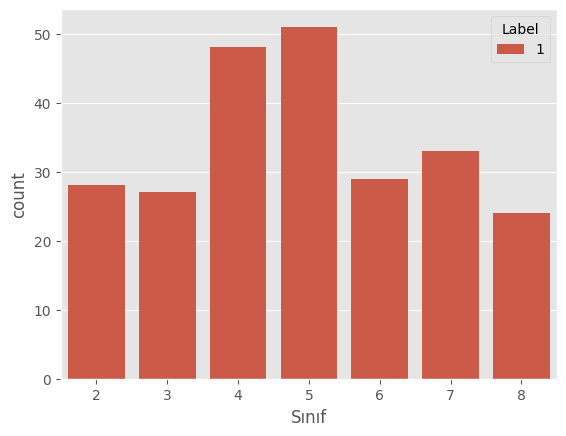

In [32]:
# Shows the Distribution of GTS with respect to Class

# Subset your data to only include Label=1
df_label_1 = df[df["Label"] == 1]

sns.countplot(x="Sınıf", hue="Label", data=df_label_1)


C:\Users\Samsung\AppData\Local\Temp\ipykernel_15180\1029728782.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 0]["S_süre"],
C:\Users\Samsung\AppData\Local\Temp\ipykernel_15180\1029728782.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]["S_süre"],


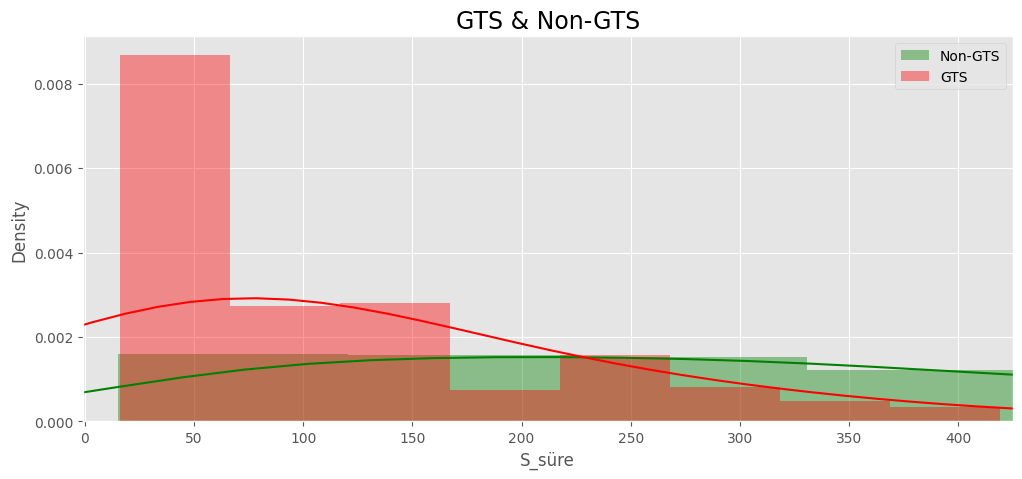

In [33]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(12,5))
sns.distplot(df[df['Label'] == 0]["S_süre"], 
             color='g', label='Non-GTS')
sns.distplot(df[df['Label'] == 1]["S_süre"], 
             color='r', label='GTS')
plt.title('GTS & Non-GTS', fontsize=17)
plt.xlim([-1,425])

# Add legend
plt.legend()

plt.show()

In [34]:
#To clearly see the data of GTS and non-GTS
df_gts = df[df['Label'] == 1]
df_nongts = df[df['Label'] == 0]

print("GTS statistics")
print(df_gts["Puan"].describe())
print("\nNon-GTS statistics")
print(df_nongts["Puan"].describe())

GTS statistics
count   240
mean     82
std      24
min      10
25%      70
50%      90
75%     100
max     100
Name: Puan, dtype: float64

Non-GTS statistics
count   6342
mean      79
std       26
min        0
25%       70
50%       90
75%      100
max      100
Name: Puan, dtype: float64


In [35]:
# import matplotlib.gridspec as gridspec

# #Looking the features relationship
# columns = df.iloc[:,1:29].columns

# GTS = df.Label == 1
# nongts = df.Label == 0

# grid = gridspec.GridSpec(14, 2)
# plt.figure(figsize=(15,20*4))

# for n, col in enumerate(df[columns]):
#     ax = plt.subplot(grid[n])
#     sns.distplot(df[col][GTS], bins = 50, color='g') #Will receive the "semi-salmon" violin
#     sns.distplot(df[col][nongts], bins = 50, color='r') #Will receive the "ocean" color
#     ax.set_ylabel('Density')
#     ax.set_title(str(col))
#     ax.set_xlabel('')
# plt.show()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582 entries, 0 to 7876
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Üye                     6582 non-null   int64   
 1   Sınav                   6582 non-null   int64   
 2   Konu                    6582 non-null   int64   
 3   Sınav Türü              6582 non-null   int64   
 4   Doğru Sayısı            6582 non-null   int64   
 5   Yanlış Sayısı           6582 non-null   int64   
 6   Boş Sayısı              6582 non-null   int64   
 7   Puan                    6582 non-null   int64   
 8   S_Giriş Zamanı          6582 non-null   int64   
 9   S_Çıkış Zamanı          6582 non-null   int64   
 10  S_süre                  6582 non-null   int64   
 11  GirişLog                6582 non-null   int64   
 12  Sınıf                   6582 non-null   int64   
 13  Ders                    6582 non-null   int64   
 14  Aktif Materyal Sayısı   

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Üye,6582,1164013379,713811725,2910824,538953896,1169761231,1744249486,2428472503
Sınav,6582,510379181695,284925231929,438484723,263878042434,523355310028,776632496251,994722286690
Konu,6582,8231,2097,3536,8121,8893,9580,10904
Sınav Türü,6582,1,2,1,1,1,1,15
Doğru Sayısı,6582,8,4,0,5,8,10,69
Yanlış Sayısı,6582,1,2,0,0,1,2,28
Boş Sayısı,6582,1,3,0,0,0,0,96
Puan,6582,79,26,0,70,90,100,100
S_Giriş Zamanı,6582,1632009542,680153,1630482682,1631475281,1632083049,1632593970,1633044992
S_Çıkış Zamanı,6582,1632010021,680154,1630483547,1631475609,1632083622,1632595239,1633046191


In [38]:
#I will select the variables where fraud class have a interesting behavior and might can help us predict

df = df[['Sınav Türü',"Puan","S_süre","Sınıf","Ders","Aktif Materyal Sayısı","total_study_time","Label"]]

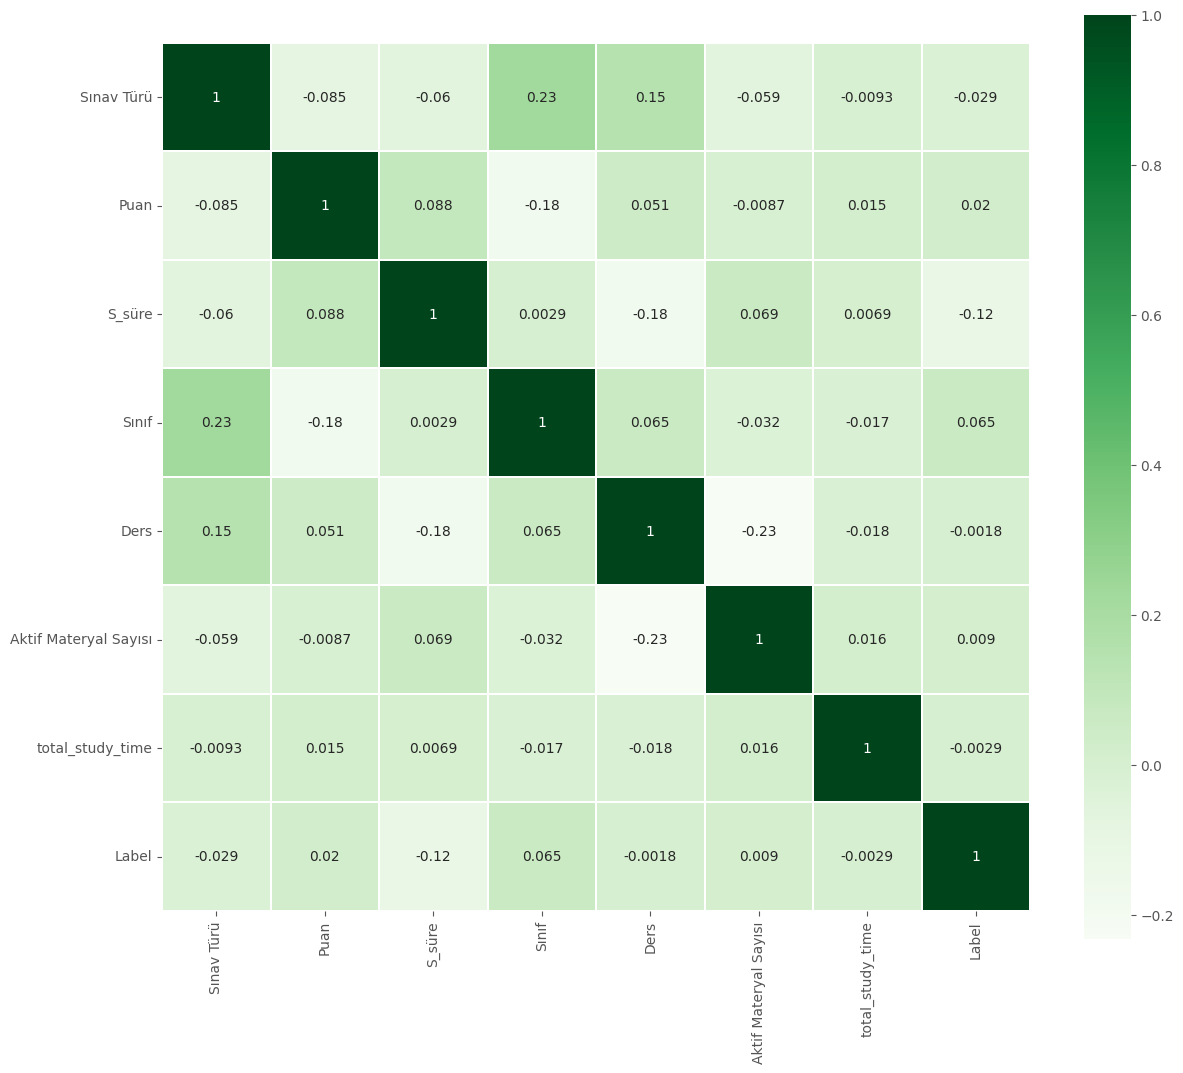

In [39]:
colormap = plt.cm.Greens

plt.figure(figsize=(14,12))

sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap = colormap, linecolor='white', annot=True)
plt.show()

In [40]:
# since we try to predict the Label column, we need to drop this column before assigning the data to X

X = df.drop('Label', axis=1).copy()
X.head()

,Sınav Türü,Puan,S_süre,Sınıf,Ders,Aktif Materyal Sayısı,total_study_time
0,1,80,237,6,2,6,3102
1,1,90,241,6,9,6,3245
3,1,90,659,6,3,6,3365
5,1,0,492,6,2,6,5825
7,1,50,73,6,1,3,2967


In [41]:
# y is the Label column which we want to predict

y = df['Label'].copy()
y.head()

0    0
1    0
3    0
5    0
7    1
Name: Label, dtype: int64

In [42]:
### Format the data 2 : One Hot Encoding 

# One Hot Encoding is not good for logistic regression but great for tree based models for categorical variables

# One Hot Encoding for categorical variables

X_encoded = pd.get_dummies(X, columns=['Sınav Türü','Sınıf','Ders'])

print(X_encoded.info())

X_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582 entries, 0 to 7876
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Puan                   6582 non-null   int64
 1   S_süre                 6582 non-null   int64
 2   Aktif Materyal Sayısı  6582 non-null   int64
 3   total_study_time       6582 non-null   int64
 4   Sınav Türü_1           6582 non-null   uint8
 5   Sınav Türü_2           6582 non-null   uint8
 6   Sınav Türü_4           6582 non-null   uint8
 7   Sınav Türü_5           6582 non-null   uint8
 8   Sınav Türü_7           6582 non-null   uint8
 9   Sınav Türü_12          6582 non-null   uint8
 10  Sınav Türü_13          6582 non-null   uint8
 11  Sınav Türü_14          6582 non-null   uint8
 12  Sınav Türü_15          6582 non-null   uint8
 13  Sınıf_1                6582 non-null   uint8
 14  Sınıf_2                6582 non-null   uint8
 15  Sınıf_3                6582 non-null  

,Puan,S_süre,Aktif Materyal Sayısı,total_study_time,Sınav Türü_1,Sınav Türü_2,Sınav Türü_4,Sınav Türü_5,Sınav Türü_7,Sınav Türü_12,Sınav Türü_13,Sınav Türü_14,Sınav Türü_15,Sınıf_1,Sınıf_2,Sınıf_3,Sınıf_4,Sınıf_5,Sınıf_6,Sınıf_7,Sınıf_8,Sınıf_23,Sınıf_41,Ders_1,Ders_2,Ders_3,Ders_4,Ders_9,Ders_11,Ders_13,Ders_14,Ders_16,Ders_17
0,80,237,6,3102,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,90,241,6,3245,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,90,659,6,3365,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0,492,6,5825,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,50,73,3,2967,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Build a preliminary XGBoost Model

In [43]:
# check the target data imbalance

sum(y)/len(y)

0.03646308113035551

In [44]:
# split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, test_size=0.2, stratify=y)   #test_size=0.2 could be added to split in %80 train and %20 test 

In [45]:
# check if stratification is done correctly

print('y_train ratio:', sum(y_train)/len(y_train))
print('y_test ratio:',sum(y_test)/len(y_test))

y_train ratio: 0.036467236467236465
y_test ratio: 0.03644646924829157


In [46]:
df["S_süre"].describe()

count   6582
mean     444
std      439
min       15
25%      163
50%      325
75%      568
max     5278
Name: S_süre, dtype: float64

In [47]:
# Create XGBClassifier model

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42) #, tree_method='gpu_hist')
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)]) 

[0]	validation_0-aucpr:0.19511
[1]	validation_0-aucpr:0.23637
[2]	validation_0-aucpr:0.26020
[3]	validation_0-aucpr:0.26105
[4]	validation_0-aucpr:0.26440


C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-aucpr:0.26062
[6]	validation_0-aucpr:0.24812
[7]	validation_0-aucpr:0.24491
[8]	validation_0-aucpr:0.25710
[9]	validation_0-aucpr:0.25552
[10]	validation_0-aucpr:0.24907
[11]	validation_0-aucpr:0.26230
[12]	validation_0-aucpr:0.27366
[13]	validation_0-aucpr:0.27409
[14]	validation_0-aucpr:0.26043
[15]	validation_0-aucpr:0.26591
[16]	validation_0-aucpr:0.26914
[17]	validation_0-aucpr:0.27751
[18]	validation_0-aucpr:0.26929
[19]	validation_0-aucpr:0.27096
[20]	validation_0-aucpr:0.25788
[21]	validation_0-aucpr:0.25748
[22]	validation_0-aucpr:0.25410
[23]	validation_0-aucpr:0.25073
[24]	validation_0-aucpr:0.24688
[25]	validation_0-aucpr:0.24694
[26]	validation_0-aucpr:0.24182


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

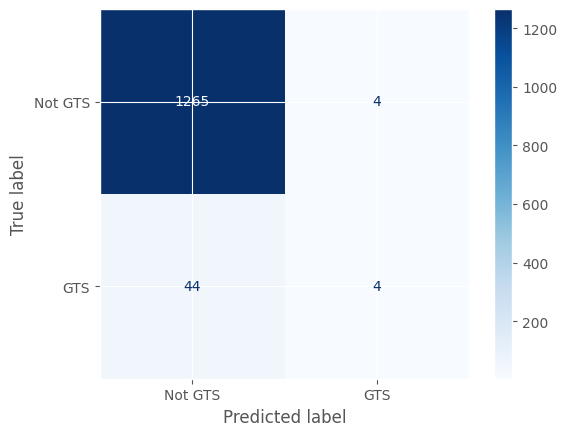

In [48]:
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_test, y_test, cmap='Blues', values_format='d' ,display_labels=['Not GTS', 'GTS'])